In [1]:
!pip install flopy

  Using cached flopy-3.7.0-py3-none-any.whl.metadata (7.7 kB)
Using cached flopy-3.7.0-py3-none-any.whl (1.5 MB)


In [2]:
import os, sys
# Temporal, para agregar las rutas correctas
%run ../../src/xmf6/ruta_temporal.py
if not(src_path in sys.path[0]):
    sys.path.insert(0, os.path.abspath(a_path + src_path)) 

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import flopy
import xmf6
from flow_1D import build_gwf_1D
from tran_1D import build_gwt_1D

In [4]:
os_par = dict(
    ws = os.getcwd() + '/output', # Ruta de donde estamos actualmente
    mf6_exe = '/home/jovyan/mf6/bin/mf6', # Ejecutable
    flow_name = 'flow', # Nombre de la simulación para flujo
    tran_name = 'transport' # Nombre de la simulación para transporte
)
xmf6.nice_print(os_par, 'MODFLOW 6 environment')
                     
oc_par = dict(
    head_file = f"{os_par['flow_name']}.hds",
    fbudget_file = f"{os_par['flow_name']}.bud",
    concentration_file=f"{os_par['tran_name']}.ucn",
    tbudget_file = f"{os_par['tran_name']}.bud",
)
xmf6.nice_print(oc_par, 'Output files')

mesh = xmf6.MeshDis(
    nrow = 1,    # Number of rows
    ncol = 120,  # Number of columns
    nlay = 1,    # Number of layers
    row_length = 12.0,    # Length of system ($cm$)
    column_length = 0.1,  # Length of system ($cm$)
    top = 1.0,   # Top of the model ($cm$)
    bottom = 0,  # Layer bottom elevation ($cm$)
)
xmf6.nice_print(mesh, 'Space discretization')

tdis = xmf6.TDis(
    perioddata = ((120, 240, 1.0),) # PERLEN, NSTP, TSMULT
)
xmf6.nice_print(tdis, 'Time discretization')

ml_units = {
    "time": "seconds",
    "length": "centimeters"
}
xmf6.nice_print(ml_units, 'Units')

ph_par = dict(
    specific_discharge = 0.1,  # Specific discharge ($cm s^{-1}$)
    hydraulic_conductivity = 0.01,  # Hydraulic conductivity ($cm s^{-1}$)
    source_concentration = 1.0,  # Source concentration (unitless)
    porosity = 0.1,  # Porosity of mobile domain (unitless)
    initial_concentration = 0.0,  # Initial concentration (unitless)
)
xmf6.nice_print(ph_par, 'Physical parameters')


MODFLOW 6 environment
------------------------------
                  ws = /home/jovyan/xmf6/examples/01_flow_trans_1D/output
             mf6_exe = /home/jovyan/mf6/bin/mf6
           flow_name = flow      
           tran_name = transport 

Output files
------------------------------
           head_file = flow.hds  
        fbudget_file = flow.bud  
  concentration_file = transport.ucn
        tbudget_file = transport.bud

Space discretization
------------------------------
NX =          120 (ncol)
NY =            1 (nrow)
NZ =            1 (nlay)
LX =       12.000 (row)
LY =        0.100 (col)
LZ =        1.000 (lay)
DX =  1.00000e-01 (delr)
DY =  1.00000e-01 (delc)
TOP=        1.000 (top)
BOT=        0.000 (bottom)
DZ =  1.00000e+00 (top-botm)
0.5

Time discretization
------------------------------
      NPER = 1       
TOTAL TIME = 120.00

PER     PERLEN     NSTP     TSMULT        Dt1
  1     120.00      240       1.00   5.00e-01

Units
------------------------------
          

# Solución del flujo: GWF

In [5]:
# Construcción del Modelo GWF
sim_f, gwf = build_gwf_1D(mesh, tdis, ph_par, ml_units, os_par, oc_par)
sim_f.write_simulation(silent=True)

In [6]:
sim_f.run_simulation(silent=True)

(True, [])

## Obtención de los datos: 

In [7]:
of = xmf6.OFiles(os_par, oc_par)
qx, _, _ = of.get_q(gwf)
head = of.get_head()
xi = mesh.get_coords('X')
print(qx)

[[[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
   0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]]]


# Solución de transporte: GWT

## Definición del caso de estudio

In [15]:
long_disp = [0.1, 1.0, 1.0, 1.0]
reta_fact = [1.0, 1.0, 2.0, 1.0]
deca_rate = [0.0, 0.0, 0.0, 0.01]
dir_names = ['p01a','p01b','p01c','p01d']

case = 1 # 0, 1, 2, 3
dirname = dir_names[case]
ph_par["longitudinal_dispersivity"] = long_disp[case] 
ph_par["retardation_factor"] = reta_fact[case]
ph_par["decay_rate"] =  deca_rate[case]
ph_par["dispersion_coefficient"] = ph_par["longitudinal_dispersivity"] * \
                                   ph_par["specific_discharge"] / ph_par["retardation_factor"]
xmf6.nice_print(ph_par, 'Physical parameters')
print("Caso: {}".format(dirname))

# Construcción del Modelo GWT
sim_t, gwt = build_gwt_1D(mesh, tdis, ph_par, ml_units, os_par, oc_par)
sim_t.write_simulation(silent=True)


Physical parameters
------------------------------
  specific_discharge = 0.1       
hydraulic_conductivity = 0.01      
source_concentration = 1.0       
            porosity = 0.1       
initial_concentration = 0.0       
longitudinal_dispersivity = 1.0       
  retardation_factor = 1.0       
          decay_rate = 0.0       
dispersion_coefficient = 0.1       
Caso: p01b


In [12]:
# Solución usando MODFLOW 6 - GWT
sim_t.run_simulation(silent=True)

# Solución usando DF-Implicit (Leo)
dfi_conc = xmf6.df_implicit.solve(ph_par, mesh, tdis, qx, verb=0)

# Análisis de la solución

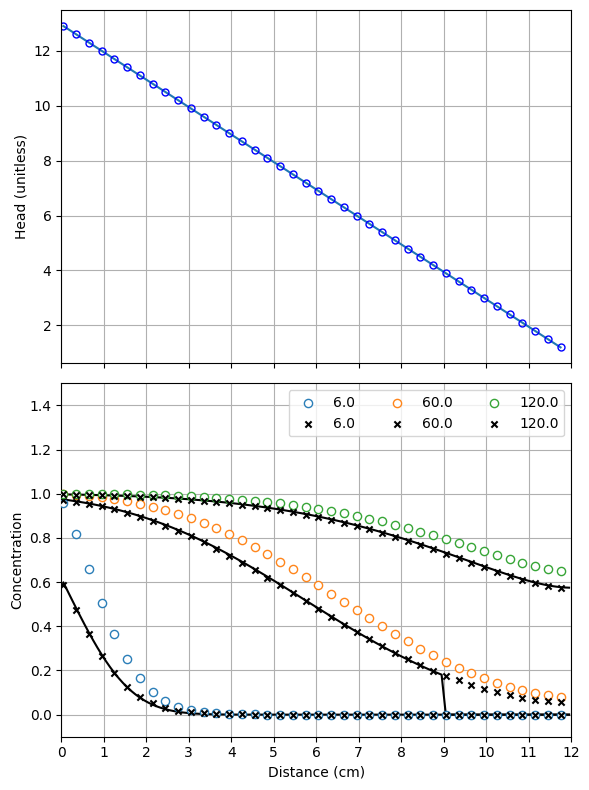

In [13]:
##### Leemos la solución analítica #####
sol_path = 'analytic/' + dirname
a1_0 = np.load(sol_path + '/a1_x_0.npy')
a1_1 = np.load(sol_path + '/a1_x_1.npy')
a1_2 = np.load(sol_path + '/a1_x_2.npy')

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,8), sharex=True)
iskip = 3

##### Carga hidraúlica #####
xmf6.plot(ax1, xi[::iskip], head[0, 0][::iskip],
            marker="o", ls ="-", 
            mec="blue", mfc="none", 
            markersize="5", label = 'Head')

ax1.set_xlim(0, 12)
ax1.set_xticks(ticks=np.linspace(0, mesh.row_length,13))
ax1.set_ylabel("Head (unitless)")
ax1.grid(True)

##### Concentración #####
# Solución analítica
xmf6.plot(ax2, xi, a1_0, c = 'k')
xmf6.plot(ax2, xi, a1_1, c = 'k')
xmf6.plot(ax2, xi, a1_2, c = 'k')

# Solución numérica
citer = [11, 119, 239]
ctimes = [6.0, 60.0, 120.0]
for c, (i, t) in enumerate(zip(citer, ctimes)):
    color = 'C'+str(c)
    # Solución Diferencias Finitas, Implícito
    xmf6.scatter(ax2, xi[::iskip], dfi_conc[i][::iskip], label=f'{t}',
                 marker="o", ec=color, fc="w", alpha=0.95, s=35, zorder=5)

    # Solución MODFLOW 6
    gwt_conc = of.get_concentration(sim_t, t)
    xmf6.scatter(ax2, xi[::iskip], gwt_conc[::iskip], label=f'{t}',
                 marker="x", c='k', s=20, zorder=5)    

ax2.legend(loc="upper right", ncol=3)
ax2.set_xlim(0, 12)
ax2.set_ylim(-0.1, 1.5)
ax2.set_xticks(ticks=np.linspace(0, mesh.row_length,13))
ax2.set_xlabel("Distance (cm)")
ax2.set_ylabel("Concentration")
ax2.grid(True)

plt.tight_layout()
plt.savefig(dirname + '.pdf')
plt.show()